# Exploratory Data Analysis (EDA)
# HR-AI Scout: Анализ данных резюме и вакансий

## 1. Настройка окружения и функции

In [1]:
import pandas as pd
import numpy as np
import warnings
import json
import re
from collections import Counter
from typing import Optional

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix
from scipy.stats import pearsonr, spearmanr

pd.options.display.float_format = '{:,.0f}'.format

In [2]:
#  Словари для приведения расчетов

rates_rub = {
    "RUB": 1.0,
    "RUR": 1.0,
    "USD": 80.851,
    "EUR": 94.141,
    "UAH": 1.9368,
    "KZT": 0.1510,
    "BYN": 26.467,
    "AZN": 47.50,
    "UZS": 0.00671,
    "GEL": 29.90,
}

currency_patterns = [
    ("RUB", r"₽|\brub\b"),
    ("USD", r"\$|\busd\b"),
    ("EUR", r"€|\beur\b"),
    ("UAH", r"₴|\buah\b"),
    ("KZT", r"₸|\bkzt\b"),
    ("BYN", r"\bbr\b|\bbyn\b"),
    ("AZN", r"₼|\bazn\b"),
    ("UZS", r"so['’`]?m|\buzs\b|\bsum\b"),
    ("GEL", r"₾|\bgel\b"),
]

RE_TRASH    = re.compile(r"(на\s*руки|in\s*hand|on\s*hand|hands?|net|чистыми)", re.I)
RE_SPACE    = re.compile(r"\s+")
RE_ANY_NUM  = re.compile(r"\d")
RE_KEEP     = re.compile(r"[^\d,.\- ]")      # всё, кроме цифр/запятой/точки/минуса/пробела
RE_DIGITS   = re.compile(r"\d+")             # запасной матч

In [3]:
def analyze_missing_values(df):

    total_cells = df.shape[0] * df.shape[1]
    total_missing = df.isnull().sum().sum()

    print(f'Общее количество ячеек: {total_cells:,}')
    print(f'Общее количество пропусков: {total_missing:,}')
    print(f'Общая разреженность датасета: {(total_missing/total_cells)*100:.2f}%')

    missing_stats = pd.DataFrame({
        'Столбец': df.columns,
        'Пропусков': df.isnull().sum().values,
        'Доля_%': (df.isnull().sum().values / len(df) * 100).round(2),
        'Тип': df.dtypes.values
    })

    missing_stats = missing_stats[missing_stats['Пропусков'] > 0].sort_values('Пропусков', ascending=False)

    # if len(missing_stats) > 0:
    #     print(f'\nСтолбцы с пропущенными значениями ({len(missing_stats)} из {len(df.columns)}):')
    #     print(missing_stats.to_string(index=False))
    # else:
    #     print('\nПропущенных значений не обнаружено!')

    return missing_stats

In [4]:
def drop_rows_where_all_selected_null(df: pd.DataFrame, cols_to_check) -> pd.DataFrame:

    cols_to_check = [c for c in cols_to_check if c in df.columns]

    df_cleaned = df.dropna(subset=cols_to_check, how="all")
    removed = len(df) - len(df_cleaned)

    print(f"Удалено {removed} строк, где все эти столбцы были NaN")

    return df_cleaned

In [5]:
def drop_inconsistent_experience(df: pd.DataFrame) -> pd.DataFrame:

    """
    Удаляет строки, где указано resume_total_experience,
    но отсутствует информация о последнем опыте (должность или описание)
    """
    inconsistent_experience  = (
        df["resume_total_experience"].notna()
        & df["resume_last_experience_description"].isna()
        & df["resume_last_position"].isna()
    )
    print(f"Удалено {int(inconsistent_experience.sum())} строк с некорректным опытом")
    return df.loc[~inconsistent_experience].copy()

In [6]:
def clean_resume_fields(df: pd.DataFrame) -> pd.DataFrame:
    """
    Комплексная очистка и заполнение пропусков в полях резюме:
      (1) Заменяет NaN, None, пустые строки и пустые массивы в колонках
          resume_courses и resume_skills на пустые списки [].
      (2) Заполняет пропуски в полях опыта:
          - resume_last_experience_description → '' (пустая строка)
          - resume_last_position → '' (пустая строка)
          - resume_last_company_experience_period → '' (пустая строка)
          - resume_total_experience → '' (пустая строка)
          - resume_experience_months → 0 (число)
    """

    # (1) Обработка списковых полей
    list_cols = ["resume_courses", "resume_skills"]

    def to_list_safe(x):
        if x is None or (isinstance(x, float) and pd.isna(x)):
            return []
        if isinstance(x, (list, np.ndarray)):
            return list(x)
        if isinstance(x, str):
            s = x.strip()
            return [] if s == "" else [s]
        return x

    for col in list_cols:
        df[col] = df[col].apply(to_list_safe)

    # (2) Заполнение пропусков в полях опыта
    experience_mapping = {
        "resume_last_experience_description": "",
        "resume_last_position": "",
        "resume_last_company_experience_period": "",
        "resume_total_experience": "",
        "resume_experience_months": 0,
    }

    for col, fill_value in experience_mapping.items():
        df[col] = df[col].fillna(fill_value)

    print(f"Обработаны столбцы: {list_cols}")
    return df


In [7]:
def fill_missing_applicant_status(df: pd.DataFrame) -> pd.DataFrame:
    """
    Обновляет колонку resume_applicant_status:
    - заменяет NaN на 'Рассматривает предложения'
    - заменяет 'Есть подтверждённые навыки' на 'Рассматривает предложения'
    """

    before_nulls = df["resume_applicant_status"].isna().sum()
    before_skills = (df["resume_applicant_status"] == "Есть подтверждённые навыки").sum()

    df["resume_applicant_status"] = df["resume_applicant_status"].fillna("Рассматривает предложения")
    df["resume_applicant_status"] = df["resume_applicant_status"].replace("Есть подтверждённые навыки", "Рассматривает предложения")

    after_nulls = df["resume_applicant_status"].isna().sum()

    print(f"Заменено {before_nulls - after_nulls} пропусков и {before_skills} значений 'Есть подтверждённые навыки'")
    return df

In [8]:
def fill_missing_education(df: pd.DataFrame) -> pd.DataFrame:
    """
    Заменяет NaN в колонке resume_education на ['среднее общее образование'].
    """

    null_values = df["resume_education"].isna().sum()

    df["resume_education"] = df["resume_education"].apply(lambda x: ['среднее общее образование'] if pd.isna(x) else x)

    print(f"Заменено {null_values} пропусков в 'resume_education'.")
    return df

In [9]:
def fill_missing_age(df: pd.DataFrame) -> pd.DataFrame:
    """
    Если resume_age = NaN:
      (1) если resume_total_experience НЕ NaN и resume_experience_months > 0:
            age = resume_experience_months // 12 + 18
      (2) если resume_total_experience = NaN и resume_experience_months == 0 и resume_education НЕ NaN:
            age = 22
      (3) если resume_total_experience = NaN и resume_experience_months == 0 и resume_education = NaN:
            age = 18
    """

    # приведение типов для надёжных сравнений
    if "resume_age" in df.columns:
        df["resume_age"] = pd.to_numeric(df["resume_age"], errors="coerce")
    else:
        df["resume_age"] = np.nan

    if "resume_experience_months" in df.columns:
        df["resume_experience_months"] = pd.to_numeric(df["resume_experience_months"], errors="coerce")
    else:
        df["resume_experience_months"] = np.nan

    m_age_nan = df["resume_age"].isna()

    # helpers
    def not_null_total_exp(x):
        return pd.notna(x) and (str(x).strip() != "")

    def has_education(val):
        if pd.isna(val):
            return False
        if isinstance(val, list):
            return len(val) > 0
        return str(val).strip() != ""

    # Условие (1): total_experience НЕ null И months > 0
    m1 = (
        m_age_nan &
        df["resume_total_experience"].apply(not_null_total_exp) &
        (df["resume_experience_months"].fillna(0) > 0)
    )
    df.loc[m1, "resume_age"] = (df.loc[m1, "resume_experience_months"].fillna(0) // 12 + 18).astype(float)

    # Условие (2): total_experience = null И months == 0 И образование НЕ null
    m2 = (
        m_age_nan &
        ~df["resume_total_experience"].apply(not_null_total_exp) &
        (df["resume_experience_months"].fillna(0) == 0) &
        df["resume_education"].apply(has_education)
    )
    df.loc[m2, "resume_age"] = 22.0

    # Условие (3): total_experience = null И months == 0 И образование = null
    m3 = (
        m_age_nan &
        ~df["resume_total_experience"].apply(not_null_total_exp) &
        (df["resume_experience_months"].fillna(0) == 0) &
        ~df["resume_education"].apply(has_education)
    )
    df.loc[m3, "resume_age"] = 18.0

    print(
        f"Пропуски заполнены по алгоритму"
    )

    return df


In [10]:
def normalize_resume_salary_to_rub(
    df: pd.DataFrame,
    col: str = "resume_salary"
) -> pd.DataFrame:
    """
    Нормализует значения зарплат в df[col] в рубли (float).
    Ожидает заранее определённые rates_rub и currency_patterns (list[(code, regex)]).
    """

    # Предкомпилируем валютные паттерны
    compiled_currency_patterns = [(code, re.compile(pat, re.I)) for code, pat in currency_patterns]

    def _normalize_text(s: str) -> str:
        # нормализуем пробелы/мусор
        s = (s.replace("\xa0", " ")
               .replace("\u2009", " ")
               .replace("\u202f", " "))
        s = RE_TRASH.sub("", s)
        s = RE_SPACE.sub(" ", s).strip().lower()
        return s

    def _detect_currency(s: str) -> Optional[str]:
        for code, rx in compiled_currency_patterns:
            if rx.search(s):
                return code
        # если нет валютных символов, но есть цифры — считаем рубли
        return "RUB" if RE_ANY_NUM.search(s) else None

    def _extract_number(s: str) -> Optional[float]:
        # оставляем только цифры/.,,/пробел/минус —> убираем пробелы
        s_digits = RE_KEEP.sub("", s).replace(" ", "")
        if not RE_ANY_NUM.search(s_digits):
            return None

        # если есть и ',' и '.', считаем ',' как разделители тысяч и выбрасываем их
        if "," in s_digits and "." in s_digits:
            s_digits = s_digits.replace(",", "")
        else:
            # иначе превращаем запятую в точку
            s_digits = s_digits.replace(",", ".")

        # если точек > 1 — оставляем только последнюю как десятичную
        if s_digits.count(".") > 1:
            parts = s_digits.split(".")
            s_digits = "".join(parts[:-1]) + "." + parts[-1]

        try:
            return float(s_digits)
        except ValueError:
            m = RE_DIGITS.search(s_digits)
            return float(m.group()) if m else None

    def _parse_one(x):
        if pd.isna(x):
            return np.nan
        s = _normalize_text(str(x))
        cur = _detect_currency(s)
        if cur is None:
            return np.nan
        amount = _extract_number(s)
        if amount is None:
            return np.nan
        rate = rates_rub.get(cur)
        if rate is None:
            return np.nan
        return float(amount) * float(rate)

    df[col] = df[col].apply(_parse_one).astype("float64")
    return df

In [11]:
def impute_resume_salary_by_specialization(
    df: pd.DataFrame,
    specialization_col: str = "resume_specialization",
    salary_col: str = "resume_salary",
    min_valid_rub: float = 20_000.0,
) -> pd.DataFrame:
    """
    Импутирует resume_salary по правилам:
      1) Строит 'моду-avg' зарплат по каждой специализации (списки раскрываются),
         игнорируя зарплаты < min_valid_rub и NaN.
         Если мод несколько — берёт их среднее.
      2) Для строк, где зарплата NaN ИЛИ < min_valid_rub:
         берёт по каждой специализации соответствующую моду и
         подставляет максимум из них.
      3) Перезаписывает df[salary_col] числом (float).
    """
    # проверки
    if specialization_col not in df.columns:
        raise ValueError(f"Нет колонки '{specialization_col}'")
    if salary_col not in df.columns:
        raise ValueError(f"Нет колонки '{salary_col}'")

    # нормализуем типы
    tmp = df.copy()
    tmp["_spec_list_"] = tmp[specialization_col].apply(
        lambda v: [str(x).strip().lower() for x in v] if isinstance(v, list)
        else ([] if pd.isna(v) else ([str(v).strip().lower()] if str(v).strip() else []))
    )
    tmp["_salary_num_"] = pd.to_numeric(tmp[salary_col], errors="coerce")

    # маски
    mask_known_good = tmp["_salary_num_"].notna() & (tmp["_salary_num_"] >= float(min_valid_rub))
    mask_need_impute = tmp["_spec_list_"].str.len().gt(0) & (
        tmp["_salary_num_"].isna() | (tmp["_salary_num_"] < float(min_valid_rub))
    )

    # 1) мода-avg по специализациям (по хорошим значениям)
    mode_avg_by_spec = {}
    known = tmp.loc[mask_known_good & tmp["_spec_list_"].str.len().gt(0), ["_spec_list_", "_salary_num_"]]
    if not known.empty:
        exploded = known.explode("_spec_list_")
        for spec, grp in exploded.groupby("_spec_list_")["_salary_num_"]:
            vals = grp.dropna().tolist()
            if not vals:
                continue
            cnt = Counter(vals)
            max_freq = max(cnt.values())
            mode_values = [v for v, f in cnt.items() if f == max_freq]
            mode_avg_by_spec[spec] = float(np.mean(mode_values))

    # 2) импутация максимумом мод по специализациям для нуждающихся строк
    def max_mode_for_specs(specs):
        vals = [mode_avg_by_spec.get(s) for s in specs]
        vals = [v for v in vals if v is not None and not np.isnan(v)]
        return max(vals) if vals else np.nan

    filled_series = tmp.loc[mask_need_impute, "_spec_list_"].apply(max_mode_for_specs)
    num_filled = filled_series.notna().sum()

    # подставляем: если была NaN или < min_valid_rub — заменить на рассчитанное (если есть)
    # где мода не нашлась — оставляем как есть (NaN или < порога)
    tmp.loc[mask_need_impute, "_salary_num_"] = np.where(
        filled_series.notna(), filled_series.values, tmp.loc[mask_need_impute, "_salary_num_"]
    )

    # 3) запись обратно
    df[salary_col] = tmp["_salary_num_"].astype(float)

    # отчёт
    print(f"Построено мод по специализациям: {len(mode_avg_by_spec)}")
    print(f"Импутировано зарплат (NaN или < {min_valid_rub:,.0f} ₽): {int(num_filled)}")

    # словарь мод — в attrs, если нужно для анализа
    df.attrs["salary_mode_avg_by_spec"] = mode_avg_by_spec
    return df

## 2. Загрузка данных

Работаем с датасетом `total_df.csv`. Скачать его можно отсюда: https://disk.yandex.ru/d/PjQ13mEbT9958w

#### **Используемые столбцы:**

- `vacancy_id` - Уникальный идентификатор вакансии
- `vacancy_name` - Название вакансии (например, «Data Analyst», «Product Manager»)
- `vacancy_area` - Регион или город, где размещена вакансия (например, «Москва»)
- `vacancy_experience` - Требуемый опыт работы (например, «Нет опыта», «1–3 года», «3–6 лет»)
- `vacancy_employment` - Тип занятости: полная, частичная, проектная, стажировка
- `vacancy_schedule` - График работы (например, «Полный день», «Удалённая работа», «Сменный график»)
- `vacancy_salary_from` - Нижняя граница зарплатного диапазона, указанная работодателем
- `vacancy_salary_to` - Верхняя граница зарплатного диапазона
- `vacancy_salary_currency` - Валюта зарплаты (например, «RUR», «USD»)
- `vacancy_salary_gross` - Признак, включены ли налоги в зарплату (True — до вычета, False — после вычета налогов)
- `vacancy_description` - Текст описания вакансии (обязанности, требования, условия)
- `resume_id` - Уникальный идентификатор резюме
- `resume_title` -  Заголовок резюме (например, «Маркетинговый аналитик», «Python-разработчик»)
- `resume_specialization` - Специализация кандидата, указанная в профиле (например, «Аналитика данных», «Финансы»)
- `resume_last_position` - Последняя должность, на которой работал кандидат
- `resume_last_experience_description` - Краткое описание обязанностей и достижений на последнем месте работы
- `resume_last_company_experience_period` - Продолжительность работы в последней компании
- `resume_skills` - Навыки, указанные в резюме (например, «Python, SQL, Tableau»)
- `resume_education` - Уровень и место образования (например, «Бакалавр, ВШЭ, Экономика»)
- `resume_courses` - Курсы повышения квалификации, сертификаты и т.п. 
- `resume_salary` - Желаемая зарплата, указанная кандидатом
- `resume_age` - Возраст кандидата (в годах)
- `resume_total_experience` - Общий трудовой стаж (например, «5 лет 2 месяца»)
- `resume_experience_months` -  Тот же стаж, но в числовом выражении (в месяцах) — для удобства анализа
- `resume_location` - Место проживания кандидата
- `resume_gender` - Пол кандидата
- `resume_applicant_status` - Текущий статус кандидата — например, «В поиске работы», «Открыт для предложений»
- `target` - 1, если кандидат соответствует критериям для первого собеседования, 0 в противном случае

In [12]:
df = pd.read_csv('total_df.csv')
df.head()

,vacancy_id,vacancy_name,vacancy_area,vacancy_experience,vacancy_employment,vacancy_schedule,vacancy_salary_from,vacancy_salary_to,vacancy_salary_currency,vacancy_salary_gross,...,resume_education,resume_courses,resume_salary,resume_age,resume_total_experience,resume_experience_months,resume_location,resume_gender,resume_applicant_status,target
0,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,"300,000",NaN,RUR,False,...,['Казанский Авиационный Институт'],NaN,NaN,65,19 лет,228,Москва,Мужчина,Рассматривает предложения,1
1,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,"300,000",NaN,RUR,False,...,"['ООО ""Открытый Учебный Центр СофтБаланс"", г. ...","['ООО ""Открытый Учебный Центр СофтБаланс"", г. ...",NaN,43,17 лет 4 месяца,208,Москва,Мужчина,Рассматривает предложения,1
2,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,"300,000",NaN,RUR,False,...,['Орский государственный педагогический инстит...,NaN,200 000 ₽ на руки,52,30 лет,360,Москва,Женщина,NaN,1
3,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,"300,000",NaN,RUR,False,...,['Красноярский государственный университет'],NaN,500 000 ₽ на руки,56,29 лет 8 месяцев,356,Красноярск,Мужчина,Рассматривает предложения,1
4,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,"300,000",NaN,RUR,False,...,['Белоруский Гос. Университет Информатики и Ра...,"['SAP CIS, SAP XI', 'Школа Логистики МАДИ', 'S...",NaN,48,25 лет 1 месяц,301,Moscow,Male,NaN,1


Приведем 'resume_salary' к общему виду (к float)

In [13]:
df = normalize_resume_salary_to_rub(df)

In [14]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
vacancy_id,"59,610",NaN,NaN,NaN,"125,229,656","2,528,382","46,152,540","125,332,317","125,731,204","126,193,151","126,563,561"
vacancy_name,59610,2720,DevOps-инженер,1539,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_area,59610,23,Москва,58841,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_experience,59610,4,От 3 до 6 лет,32229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_employment,59610,3,Полная занятость,57821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_schedule,59610,5,Удаленная работа,29976,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_salary_from,"14,031",NaN,NaN,NaN,"171,857","114,920",25,"100,000","150,000","220,000","1,000,000"
vacancy_salary_to,"11,257",NaN,NaN,NaN,"219,640","125,978",35,"150,000","200,000","300,000","1,000,000"
vacancy_salary_currency,17597,3,RUR,16378,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_salary_gross,17597,2,False,12510,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
print('=' * 80)
print('ДАТАСЕТ ВАКАНСИЙ')
print('=' * 80)
print(f'Форма данных: {df.shape}')
print(f'Столбцы: {list(df.columns)}')
print(f'Типы данных:')
print(df.dtypes)

ДАТАСЕТ ВАКАНСИЙ
Форма данных: (59610, 28)
Столбцы: ['vacancy_id', 'vacancy_name', 'vacancy_area', 'vacancy_experience', 'vacancy_employment', 'vacancy_schedule', 'vacancy_salary_from', 'vacancy_salary_to', 'vacancy_salary_currency', 'vacancy_salary_gross', 'vacancy_description', 'resume_id', 'resume_title', 'resume_specialization', 'resume_last_position', 'resume_last_experience_description', 'resume_last_company_experience_period', 'resume_skills', 'resume_education', 'resume_courses', 'resume_salary', 'resume_age', 'resume_total_experience', 'resume_experience_months', 'resume_location', 'resume_gender', 'resume_applicant_status', 'target']
Типы данных:
vacancy_id                                 int64
vacancy_name                              object
vacancy_area                              object
vacancy_experience                        object
vacancy_employment                        object
vacancy_schedule                          object
vacancy_salary_from                      

In [16]:
analyze_missing_values(df)

Общее количество ячеек: 1,669,080
Общее количество пропусков: 307,206
Общая разреженность датасета: 18.41%


,Столбец,Пропусков,Доля_%,Тип
7,vacancy_salary_to,48353,81,float64
6,vacancy_salary_from,45579,76,float64
8,vacancy_salary_currency,42013,70,object
9,vacancy_salary_gross,42013,70,object
26,resume_applicant_status,40095,67,object
19,resume_courses,35899,60,object
20,resume_salary,26695,45,float64
17,resume_skills,15136,25,object
21,resume_age,3281,6,float64
18,resume_education,1520,3,object


На данный момент в датасете 2720 вакансий 17416 резюме

Эти две таблицы соединены декартовым произведением, однако, доступно лишь  59,610 записей, которым был дан признак target, где 1 - это вакансия подходит для собеседования и 0 - эта вакансия не подходит для собеседования

25,520 -  значений target = 1

34,090 - значений target = 0

Пропущены значения у следующих параметров и по ним следующие причины отсутствия значений:

- vacancy_salary_to - работодатели редко дают зарплатные вилки, только если либо позицию им нужно (а) быстро закрыть (б) очистить входной поток, чтобы не было много невалидных подач (кандидатов с ожиданиями выше вакансии) (в) Скрыть высокие зарплаты
- vacancy_salary_from - работодатели редко дают зарплатные вилки, это им невыгодно по многим причинам. Вилки дают только если либо нужно (а) быстро закрыть позицию (б) очистить входной поток, чтобы не было много невалидных подач (кандидатов с ожиданиями выше вакансии)
- vacancy_salary_currency - вытекает из предыдущих параметров
- vacancy_salary_gross - вытекает из предыдущих параметров
- resume_applicant_status - статус аппликанта часто скрывается, если он в данный момент трудоустроен. По сути тут два типа резюме: активно ищущих и открытых предложениям.
- resume_courses - курсы кандидата на вакансию (список с названиями курсов). Необходимы для вакансий, где таковые курсы требуются. Людей таких много, курсы разные, будем ставить пустые списки у тех, у кого нет курсов
- resume_salary - Кандидаты также редко ставят ожидания по зарплатам открытыми
- resume_skills - скиллы, могут пересекаться с курсами. Это поле заметно чаще прописывают, чем курсы, потому что здесь не нужно подтверждение никакого. Пропуски говорят о незаполненном резюме. 
- resume_age - вообще на hh почти скрыть возраст. Таких резюме меньше 5%. Значит, технические ошибки при парсинге, случайные сбои.
- resume_education - отсутствие образование также редкое явление. Неоконченное также указывают, поэтому либо решили только среднее не указывать, а оставить только курсы, либо технические ошибки при парсинге, случайные сбои
- resume_last_experience_description - Отсутствие опыта или технический сбой
- resume_last_position - вытекает из предыдущего
- resume_last_company_experience_period - вытекает из предыдущего
- resume_total_experience - Отсутствие опыта или технический сбой
- resume_experience_months - вытекает из предыдущего
- resume_specialization - технический сбой
- resume_location - технический сбой
- resume_gender - технический сбой
- resume_title - технический сбой

Отсюда вытекают 3 категории:

1. **Рандомные пропуски** Технические ошибки при парсинге, случайные сбои. К ним относятся поля для резюме - одновременное отсутствие всех данных кандидата, отсутствие каких-либо данных по кандидату, кроме профессии, в которую он стремиться, отсутствие специализации и опыта

2. **Не Рандомные пропуски** Высокие зарплаты намеренно скрываются; кандидаты с пробелами в карьере не указывают даты

3. **Микс** - возможно включает технические сбои, возможно, намеренное скрытие. Требует детального рассмотрения каждого поля.

Не рандомные пропуски нужно отдельно обрабатывать, технические сбои - будут удалены из датасета


In [17]:
# Здесь мы воспользуемся функциями по удалению строк в датасете с техническими сбоями (причину смотрите выше)

cols_to_check = [
    "resume_education",
    "resume_last_experience_description",
    "resume_last_position",
    "resume_last_company_experience_period",
    "resume_total_experience",
    "resume_experience_months",
    "resume_location",
    "resume_specialization",
    "resume_gender",
    "resume_title"
]
df = drop_rows_where_all_selected_null(df, cols_to_check)

cols_to_check = [
    "resume_education",
    "resume_last_experience_description",
    "resume_last_position",
    "resume_last_company_experience_period",
    "resume_total_experience",
    "resume_experience_months",
    "resume_location",
    "resume_specialization"
]
df = drop_rows_where_all_selected_null(df, cols_to_check)

cols_to_check = [
    "resume_total_experience",
    "resume_location",
    "resume_specialization",
    "resume_gender",
    "resume_title"
]
df = drop_rows_where_all_selected_null(df, cols_to_check)

cols_to_check = [
    "resume_total_experience",
    "resume_last_experience_description",
    "resume_skills",
    "resume_courses"
]
df = drop_rows_where_all_selected_null(df, cols_to_check)

df = drop_inconsistent_experience(df)

Удалено 64 строк, где все эти столбцы были NaN
Удалено 1 строк, где все эти столбцы были NaN
Удалено 0 строк, где все эти столбцы были NaN
Удалено 267 строк, где все эти столбцы были NaN
Удалено 188 строк с некорректным опытом


Заменим текущий формат разброса полов в датасете на унифицированный: 

In [18]:
gender_map = {
    'Мужчина': 'Мужчина',
    'Male': 'Мужчина',
    'Чоловік': 'Мужчина',
    'Женщина': 'Женщина',
    'Female': 'Женщина',
    'Пол не указан': 'Неизвестно',
    'Gender unknown': 'Неизвестно'
}

df['resume_gender'] = df['resume_gender'].map(gender_map).fillna('Неизвестно')

Теперь, некоторые кандидаты не указали ни курсы (60%), которые они заканчивали, ни навыки, которые пригодились бы к той или иной информации.

Можно предположить, что даже если кандидат навыками обладает, то спрогнозировать для каждого, какие курсы тот или иной кандидат заканчивал или каким списком навыков он / она обладает - задача непростая и абсолютно ненужная

В данном контексте было решено превратить пустые навыки и курсы - в пустые списки. Таким образом, мы будем относиться к этим параметрам, как и сотрудники HR бы отнеслись - будто этих навыков и нет.

Потому что сейчас у нас основная задача - определить, попадет ли кандидат на собеседование на потенциальную вакансию или нет.

Вдобавок, заполним пропуски в полях опыта, для тех, у кого опыта нет (таких ~ 5%):
- resume_last_experience_description → '' (пустая строка)
- resume_last_position → '' (пустая строка)
- resume_last_company_experience_period → '' (пустая строка)
- resume_total_experience → '' (пустая строка)
- resume_experience_months → 0 (число)

In [19]:
df = clean_resume_fields(df)

Обработаны столбцы: ['resume_courses', 'resume_skills']


По техническим причинам, на hh.ru нельзя не указывать возраст. Однако, в датасете есть резюме без указания возраста. Для таких кандидатов был придуман наглядный способ цоенить возраст кандидата, как это бы сделал HR:

  (1) если в резюме указан опыт работы и он ненулевой, то возраст кандидата будем считать по формуле:
        age = кол-во месяцев опыта // 12 + 18
  (2) если не было опыта работы, но есть образование, то тогда:
        age = 22
  (3) если нет ни опыта, ни образования:
        age = 18

In [20]:
df = fill_missing_age(df)

Пропуски заполнены по алгоритму


Кандидатов мы делим на 2 категории: те, кто активно ищет работу и тех, кто рассматривает предложения. Если бы потенциальный соискатель не искал бы работу, он бы не оставлял открытым свое резюме для просмотра.

In [21]:
df = fill_missing_applicant_status(df)

Заменено 39755 пропусков и 43 значений 'Есть подтверждённые навыки'


Если у кандидата не указан уровень или место образования, то за него можно поставить, как минимум уровень "среднего общего образования".
Идея тут очень простая: большинство кандидатов (>95%) указали свое образование. Некоторые, у кого не указано образование, указали пройденные курсы и навыки.
Если бы кандидат заканчивал среднее специальное образование или вуз, то он бы его указал. В ином случае - ставим всем "среднее общее", потому что они его должны были получить.

In [22]:
df = fill_missing_education(df)

Заменено 1191 пропусков в 'resume_education'.


Заполним поля опыта для резюме, у которых нет желаемой зарплаты
Для этого, разобьем существующий датасет с желаемыми зарплатами кандидатов и их специализацией
Возьмем моду этих ождиаемых зарплат (если их несколько, то возьмем среднее)
И приложим получившиеся значения к ожидаемым зарплатам кандидатов с пропусками

In [23]:
df = impute_resume_salary_by_specialization(df)

Построено мод по специализациям: 1118
Импутировано зарплат (NaN или < 20,000 ₽): 23944


Таковых кандидатов не очень много, поэтому соберем дополнительный датасет с резюме без ожидаемых зарплат и соберем более подробный анализ и потенциальную вилку, на которую эти кандидаты могли бы рассчитывать:

- Способ расчета - https://disk.yandex.ru/i/_ZZOuWSGeJuZPA
- Ссылка на датасет - https://disk.yandex.ru/d/K_jItSSdr5tY-Q

In [24]:
rcs = pd.read_csv('resumes_with_salary.csv')
rcs = rcs[['resume_id', 'resume_salary']]

df_null = df[df['resume_salary'].isna()].copy()
df_notnull = df[~df['resume_salary'].isna()].copy()

merged_null = df_null.merge(rcs, on='resume_id', how='left', suffixes=('', '_rcs'))

merged_null['resume_salary'] = merged_null['resume_salary'].combine_first(merged_null['resume_salary_rcs'])

merged_null = merged_null[df.columns]

df = pd.concat([df_notnull, merged_null], ignore_index=True)

df = df[df.columns.tolist()]

Также, соберем датасет с вилками зарплат по вакансиям. Воспользуемся также помощью LLM в сборе необходимых вилок:

- Способ расчета - https://disk.yandex.ru/i/JvPOVFW1I5IwTg
- Ссылка на датасет - https://disk.yandex.ru/d/b9NyOVucJo8AGA

In [25]:
vcs = pd.read_csv('vacancies_with_salaries.csv')
vcs = vcs[[
    'vacancy_name', 'vacancy_area', 'vacancy_experience',
    'vacancy_employment', 'vacancy_schedule',
    'vacancy_salary_from', 'vacancy_salary_to'
]]
vcs['vacancy_salary_currency'] = 'RUR'
vcs['vacancy_salary_gross'] = True

df_null = df[df['vacancy_salary_from'].isna()].copy()
df_notnull = df[~df['vacancy_salary_from'].isna()].copy()

join_keys = [
    'vacancy_name', 'vacancy_area', 'vacancy_experience',
    'vacancy_employment', 'vacancy_schedule'
]

merged_null = df_null.merge(vcs, on=join_keys, how='left', suffixes=('', '_vcs'))

for col in ['vacancy_salary_from', 'vacancy_salary_to',
            'vacancy_salary_currency', 'vacancy_salary_gross']:
    merged_null[col] = merged_null[col].combine_first(merged_null[f'{col}_vcs'])

merged_null = merged_null[df.columns]

df = pd.concat([df_notnull, merged_null], ignore_index=True)

df = df[df.columns.tolist()]

Также, некоторые работодатели (меньше 5%) не оставили потолка вилки по вакансии. Поэтому было решено прикинуть примерно на основе остальных вакансий, какой будет медианный разброс вилки и дополнить эти пропуски:

In [26]:
# вычисляем медианную относительную разницу между salary_to и salary_from
valid = df[df['vacancy_salary_to'].notna()]
median_diff = np.median(
    (valid['vacancy_salary_to'] - valid['vacancy_salary_from']) / valid['vacancy_salary_from']
)

# заполняем vacancy_salary_to = vacancy_salary_from * (1 + median_diff), если vacancy_salary_to isna
mask_null_to = df['vacancy_salary_to'].isna()
df.loc[mask_null_to, 'vacancy_salary_to'] = (
    df.loc[mask_null_to, 'vacancy_salary_from'] * (1 + median_diff)
)

In [27]:
analyze_missing_values(df)

Общее количество ячеек: 1,654,520
Общее количество пропусков: 0
Общая разреженность датасета: 0.00%


,Столбец,Пропусков,Доля_%,Тип


Отлично! Пропущенные значения в датасете мы заполнили. Перейдем к следующему этапу, необходимо разобраться с выбросами и ошибочными значениями.

Рассмотрим только количественные данные датасета:

In [28]:
df[['vacancy_name', 'vacancy_salary_from' , 'vacancy_salary_to']].drop_duplicates().describe()

,vacancy_salary_from,vacancy_salary_to
count,"3,044","3,044"
mean,"190,040","347,791"
std,"70,010","142,007"
min,25,35
25%,"161,000","264,000"
50%,"186,000","345,000"
75%,"221,000","414,000"
max,"1,000,000","1,913,043"


In [29]:
df[['resume_id', 'resume_salary' , 'resume_age', 'resume_experience_months']].drop_duplicates().describe()

,resume_id,resume_salary,resume_age,resume_experience_months
count,"17,182","17,182","17,182","17,182"
mean,"47,596,065","178,897",44,211
std,"41,777,153","789,895",31,122
min,349,1,18,0
25%,"10,986,282","75,000",36,120
50%,"38,422,080","130,000",42,209
75%,"69,258,649","190,000",50,285
max,"208,416,487","99,999,999","1,967","1,354"


Можно заметить, что есть выбросы в ожидаемых зарплатах, возрасте, опыте. Также, надо убедиться, что зарплатные вилки вакансий можно сравнивать с зарплатными ожиданиями кандидатов + проверить, правильно ли записаны зарплатные вилки (конец > начало)

Преобразуем 'vacancy_salary_from' , 'vacancy_salary_to', чтобы их можно было сравнивать с 'resume_salary'

In [30]:

for col in ['vacancy_salary_from', 'vacancy_salary_to']:
    df[col] = df.apply(
        lambda row: row[col] * rates_rub.get(row['vacancy_salary_currency'], 1)
        if pd.notna(row[col]) else None,
        axis=1
    )


for col in ['vacancy_salary_from', 'vacancy_salary_to']:
    df[col] = df.apply(
        lambda row: row[col] * 0.87 if pd.notna(row[col]) and row.get('vacancy_salary_gross') else row[col],
        axis=1
    )

df[['vacancy_salary_from', 'vacancy_salary_to']] = df[['vacancy_salary_from', 'vacancy_salary_to']].round(0)

df = df.drop(columns=['vacancy_salary_gross', 'vacancy_salary_currency'], errors='ignore')

Уберем отрицательные разницы между 'vacancy_salary_to' и 'vacancy_salary_from'

Возьмем 'vacancy_salary_to', который больше на (1 + медиана интервала по корректным значениям в датасете) * 'vacancy_salary_from'

In [31]:
# Избавимся от отрицательных значений

mask_negative_diff = df['vacancy_salary_to'] < df['vacancy_salary_from']

df.loc[mask_negative_diff, 'vacancy_salary_to'] = (
    df.loc[mask_negative_diff, 'vacancy_salary_from'] * (1 + median_diff)
)

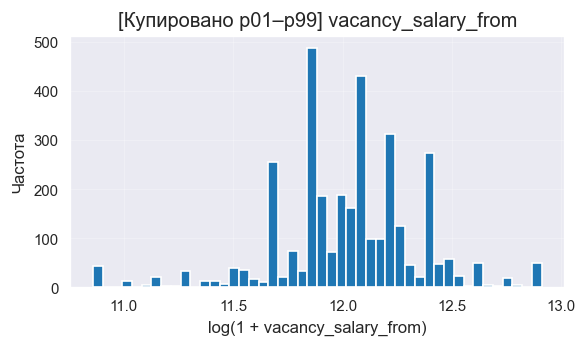

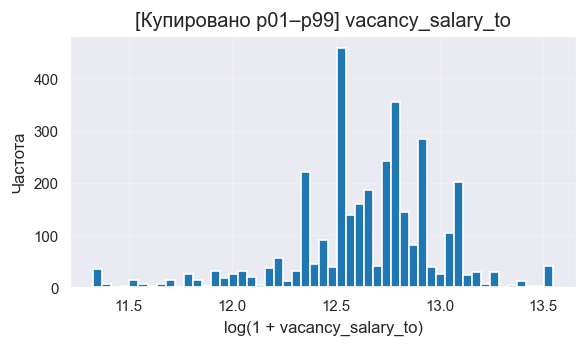

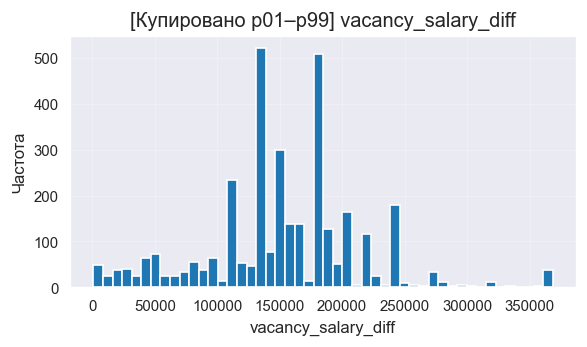

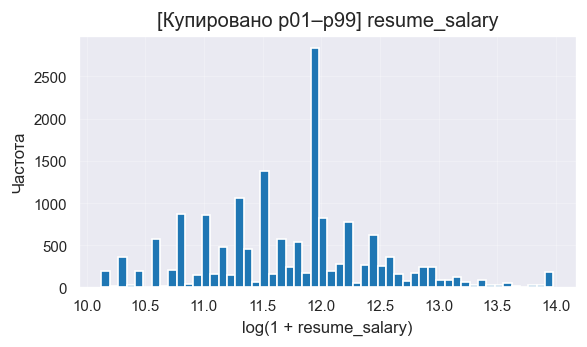

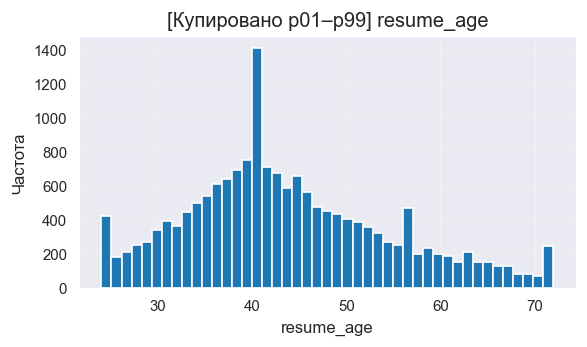

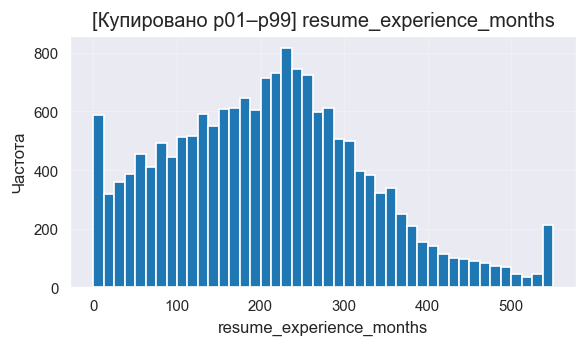

Пороговые значения купирования (p01/p99):
  vac::vacancy_salary_from: p01=52000.000, p99=404255.000
  vac::vacancy_salary_to: p01=83217.000, p99=765217.000
  vac::vacancy_salary_diff: p01=864.280, p99=368791.200
  rsc::resume_salary: p01=25000.000, p99=1175700.000
  rsc::resume_age: p01=24.000, p99=72.000
  rsc::resume_experience_months: p01=0.000, p99=550.000


In [32]:
# -------------------- Настройки графиков (компактно) --------------------
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

# -------------------- Параметры купирования --------------------
LOWER_Q = 0.01
UPPER_Q = 0.99

# -------------------- Хелперы --------------------
def normalize_cell_for_dedup(x):
    """
    Делает ячейку хэшируемой для drop_duplicates:
    - list/tuple/set/dict сериализуем в JSON-строку (с сортировкой ключей)
    - остальное оставляем как есть
    """
    if isinstance(x, (list, tuple, set, dict)):
        try:
            return json.dumps(x, ensure_ascii=False, sort_keys=True)
        except Exception:
            return str(x)
    return x

def make_dedup_df(df, cols):
    """Собирает подтаблицу, нормализует списокоподобные значения и снимает дубликаты."""
    sub = df.loc[:, cols].copy()
    # нормализуем только object-колонки (там чаще всего лежат списки/словари)
    obj_cols = [c for c in sub.columns if sub[c].dtype == "O"]
    for c in obj_cols:
        sub[c] = sub[c].apply(normalize_cell_for_dedup)
    sub = sub.drop_duplicates().copy()
    return sub

def freedman_diaconis_bins(x: np.ndarray, min_bins: int = 20, max_bins: int = 120) -> int:
    x = x[~np.isnan(x)]
    if x.size < 2:
        return min_bins
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    if iqr <= 0:
        return min_bins
    h = 2 * iqr / np.cbrt(x.size)
    if h <= 0:
        return min_bins
    bins = int(np.clip(np.ceil((x.max() - x.min()) / h), min_bins, max_bins))
    return max(bins, min_bins)

def winsorize_series(s: pd.Series, lower_q=0.01, upper_q=0.99):
    x = pd.to_numeric(s, errors="coerce")
    lo = x.quantile(lower_q)
    hi = x.quantile(upper_q)
    return x.clip(lower=lo, upper=hi), float(lo), float(hi)

def hist_plot(series: pd.Series, title: str, xlabel: str, log_x: bool = False):
    x = pd.to_numeric(series, errors="coerce").dropna().to_numpy()
    if x.size == 0:
        print(f"[WARN] {title}: нет данных")
        return
    if log_x:
        x = np.log1p(np.clip(x, a_min=0, a_max=None))
        xlabel = f"log(1 + {xlabel})"
    bins = freedman_diaconis_bins(x)
    plt.figure(figsize=(5, 3))     # компактнее прежнего
    plt.hist(x, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Частота")
    plt.tight_layout()
    plt.show()

# -------------------- Формируем vac (без дублей) --------------------
vac_cols = [
    "vacancy_id", "vacancy_name", "vacancy_area", "vacancy_experience",
    "vacancy_employment", "vacancy_schedule",
    "vacancy_salary_from", "vacancy_salary_to",
    "vacancy_description"
]
vac = make_dedup_df(df, [c for c in vac_cols if c in df.columns])

# Числовые приведения
for c in ["vacancy_salary_from", "vacancy_salary_to"]:
    if c in vac.columns:
        vac[c] = pd.to_numeric(vac[c], errors="coerce")

# Разница вилки, если обе есть
if all(c in vac.columns for c in ["vacancy_salary_from", "vacancy_salary_to"]):
    vac["vacancy_salary_diff"] = vac["vacancy_salary_to"] - vac["vacancy_salary_from"]

# -------------------- Формируем rsc (без дублей) --------------------
rsc_cols = [
    "resume_id", "resume_title", "resume_specialization", "resume_last_position",
    "resume_last_experience_description", "resume_last_company_experience_period",
    "resume_skills", "resume_education", "resume_courses",
    "resume_salary", "resume_age", "resume_total_experience", "resume_experience_months"
]
rsc = make_dedup_df(df, [c for c in rsc_cols if c in df.columns])

for c in ["resume_salary", "resume_age", "resume_experience_months"]:
    if c in rsc.columns:
        rsc[c] = pd.to_numeric(rsc[c], errors="coerce")

# -------------------- Список полей для гистограмм --------------------
vac_fields = [c for c in ["vacancy_salary_from", "vacancy_salary_to", "vacancy_salary_diff"] if c in vac.columns]
rsc_fields = [c for c in ["resume_salary", "resume_age", "resume_experience_months"] if c in rsc.columns]

# Где используем лог-шкалу по X
logx_for = {"vacancy_salary_from", "vacancy_salary_to", "resume_salary"}

# -------------------- Купирование и построение --------------------
caps = {}

# VAC
for col in vac_fields:
    capped, lo, hi = winsorize_series(vac[col], LOWER_Q, UPPER_Q)
    caps[f"vac::{col}"] = {"p01": lo, "p99": hi}
    hist_plot(capped, f"[Купировано p01–p99] {col}", col, log_x=(col in logx_for))

# RSC
for col in rsc_fields:
    capped, lo, hi = winsorize_series(rsc[col], LOWER_Q, UPPER_Q)
    caps[f"rsc::{col}"] = {"p01": lo, "p99": hi}
    hist_plot(capped, f"[Купировано p01–p99] {col}", col, log_x=(col in logx_for))

# -------------------- Печатаем пороги --------------------
print("Пороговые значения купирования (p01/p99):")
for k, v in caps.items():
    print(f"  {k}: p01={v['p01']:.3f}, p99={v['p99']:.3f}")


Уберем крайние значения (выбросы):

In [33]:
df = df[(df['vacancy_salary_from'].between(10000, 2000000)) & (df['resume_age'].between(16, 85)) & (df['resume_experience_months'].between(0, 600)) & (df['resume_salary'].between(10_000, 2_000_000))]

Теперь рассмотрим выбросы среди признако 'resume_last_experience_description' и 'vacancy_description'

=== vacancy_description ===


,value
count,"3,365"
mean,"2,287"
std,915
min,218
p01,734
p25,"1,654"
p50,"2,163"
p75,"2,769"
p99,"5,278"
max,"7,699"


=== resume_last_experience_description ===


,value
count,"16,666"
mean,732
std,952
min,1
p01,20
p25,193
p50,450
p75,926
p99,"4,252"
max,"22,345"


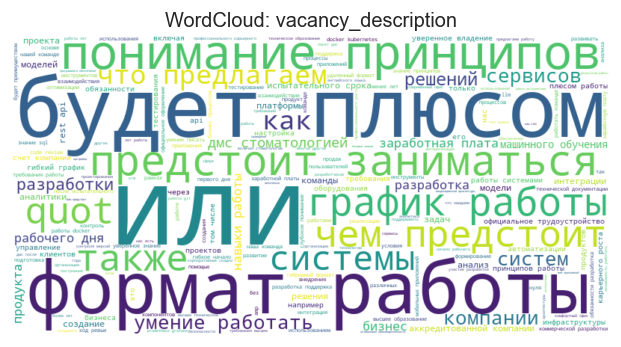

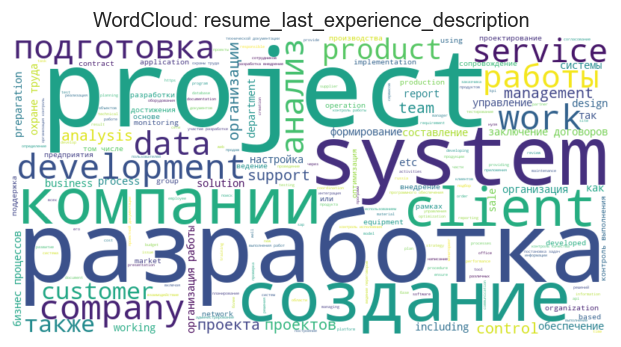

In [34]:
# -*- coding: utf-8 -*-
"""
Проверка на выбросы по количеству символов и построение wordcloud
для df.vacancy_description и df.resume_last_experience_description.
"""

# -------------------- Подготовка данных --------------------
def clean_and_dedup(series: pd.Series) -> pd.Series:
    """Удаляет NaN, дубликаты и лишние пробелы"""
    s = series.dropna().drop_duplicates().astype(str)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()
    return s[s != ""]

vac_text = clean_and_dedup(df["vacancy_description"])
rsc_text = clean_and_dedup(df["resume_last_experience_description"])

# -------------------- Метрики длины --------------------
def length_stats(series: pd.Series) -> pd.DataFrame:
    lengths = series.str.len()
    desc = lengths.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
    iqr = desc["75%"] - desc["25%"]
    iqr_low, iqr_high = desc["25%"] - 1.5 * iqr, desc["75%"] + 1.5 * iqr
    winsor_low, winsor_high = desc["1%"], desc["99%"]
    outliers_iqr = ((lengths < iqr_low) | (lengths > iqr_high)).sum()
    outliers_winsor = ((lengths < winsor_low) | (lengths > winsor_high)).sum()
    return pd.DataFrame({
        "count": [len(lengths)],
        "mean": [desc["mean"]],
        "std": [desc["std"]],
        "min": [desc["min"]],
        "p01": [desc["1%"]],
        "p25": [desc["25%"]],
        "p50": [desc["50%"]],
        "p75": [desc["75%"]],
        "p99": [desc["99%"]],
        "max": [desc["max"]],
        "iqr_low": [iqr_low],
        "iqr_high": [iqr_high],
        "winsor_low": [winsor_low],
        "winsor_high": [winsor_high],
        "outliers_iqr_cnt": [outliers_iqr],
        "outliers_winsor_cnt": [outliers_winsor],
    }).T.rename(columns={0: "value"})

print("=== vacancy_description ===")
display(length_stats(vac_text))

print("=== resume_last_experience_description ===")
display(length_stats(rsc_text))

# -------------------- WordCloud --------------------

try:
    from wordcloud import WordCloud
    use_wc = True
except ImportError:
    print("[INFO] Библиотека wordcloud не установлена — будет bar chart топ-слов.")
    use_wc = False

stopwords = {
    "и","в","на","по","с","во","для","из","от","о","до","к","при","над",
    "the","a","an","and","of","in","on","to","for","at","from","is","are",
    "as","with","by","it","was","be","this","that","these","those","we",
    "you","he","she","they","i","me","my","our","your","their","or","not",
    "опыт","работа","задачи","проект","компания","год","месяц","данные","данных"
}

def tokenize(text: str):
    text = re.sub(r"[^0-9A-Za-zА-Яа-яёЁ]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip().lower()
    return [w for w in text.split() if len(w) > 2 and w not in stopwords]

def build_corpus(series: pd.Series):
    tokens = []
    for t in series:
        tokens.extend(tokenize(t))
    return tokens

def plot_wordcloud(series: pd.Series, title: str):
    tokens = build_corpus(series)
    if not tokens:
        print(f"[WARN] {title}: нет токенов для отображения.")
        return
    if use_wc:
        text = " ".join(tokens)
        wc = WordCloud(width=800, height=400, background_color="white")
        img = wc.generate(text)
        plt.figure(figsize=(6, 3))
        plt.imshow(img, interpolation="bilinear")
        plt.axis("off")
        plt.title(title)
        plt.tight_layout()
        plt.show()
    else:
        top = Counter(tokens).most_common(25)
        words, freqs = zip(*top)
        plt.figure(figsize=(6, 4))
        y = np.arange(len(words))
        plt.barh(y, freqs)
        plt.yticks(y, words)
        plt.gca().invert_yaxis()
        plt.xlabel("Частота")
        plt.title(title + " (top-25)")
        plt.tight_layout()
        plt.show()

plot_wordcloud(vac_text, "WordCloud: vacancy_description")
plot_wordcloud(rsc_text, "WordCloud: resume_last_experience_description")


Критических выбросов замечено не было

Маленькое кол-во элементов в 'resume_last_experience_description' говорит о том, что либо

1. У пользователя не было опыта
2. Последний опыт характеризуется в нескольких словах



=== Corr with target (numeric only), sorted by |Pearson r| ===
                 feature  pearson_r  pearson_p  spearman_rho  spearman_p     n
               resume_id          0          0             0           0 58302
              resume_age         -0          0            -0           0 58302
resume_experience_months         -0          0            -0           0 58302
           resume_salary          0          0             0           0 58302
       vacancy_salary_to         -0          0            -0           0 58302
     vacancy_salary_from         -0          0            -0           0 58302
              vacancy_id          0          1            -0           1 58302


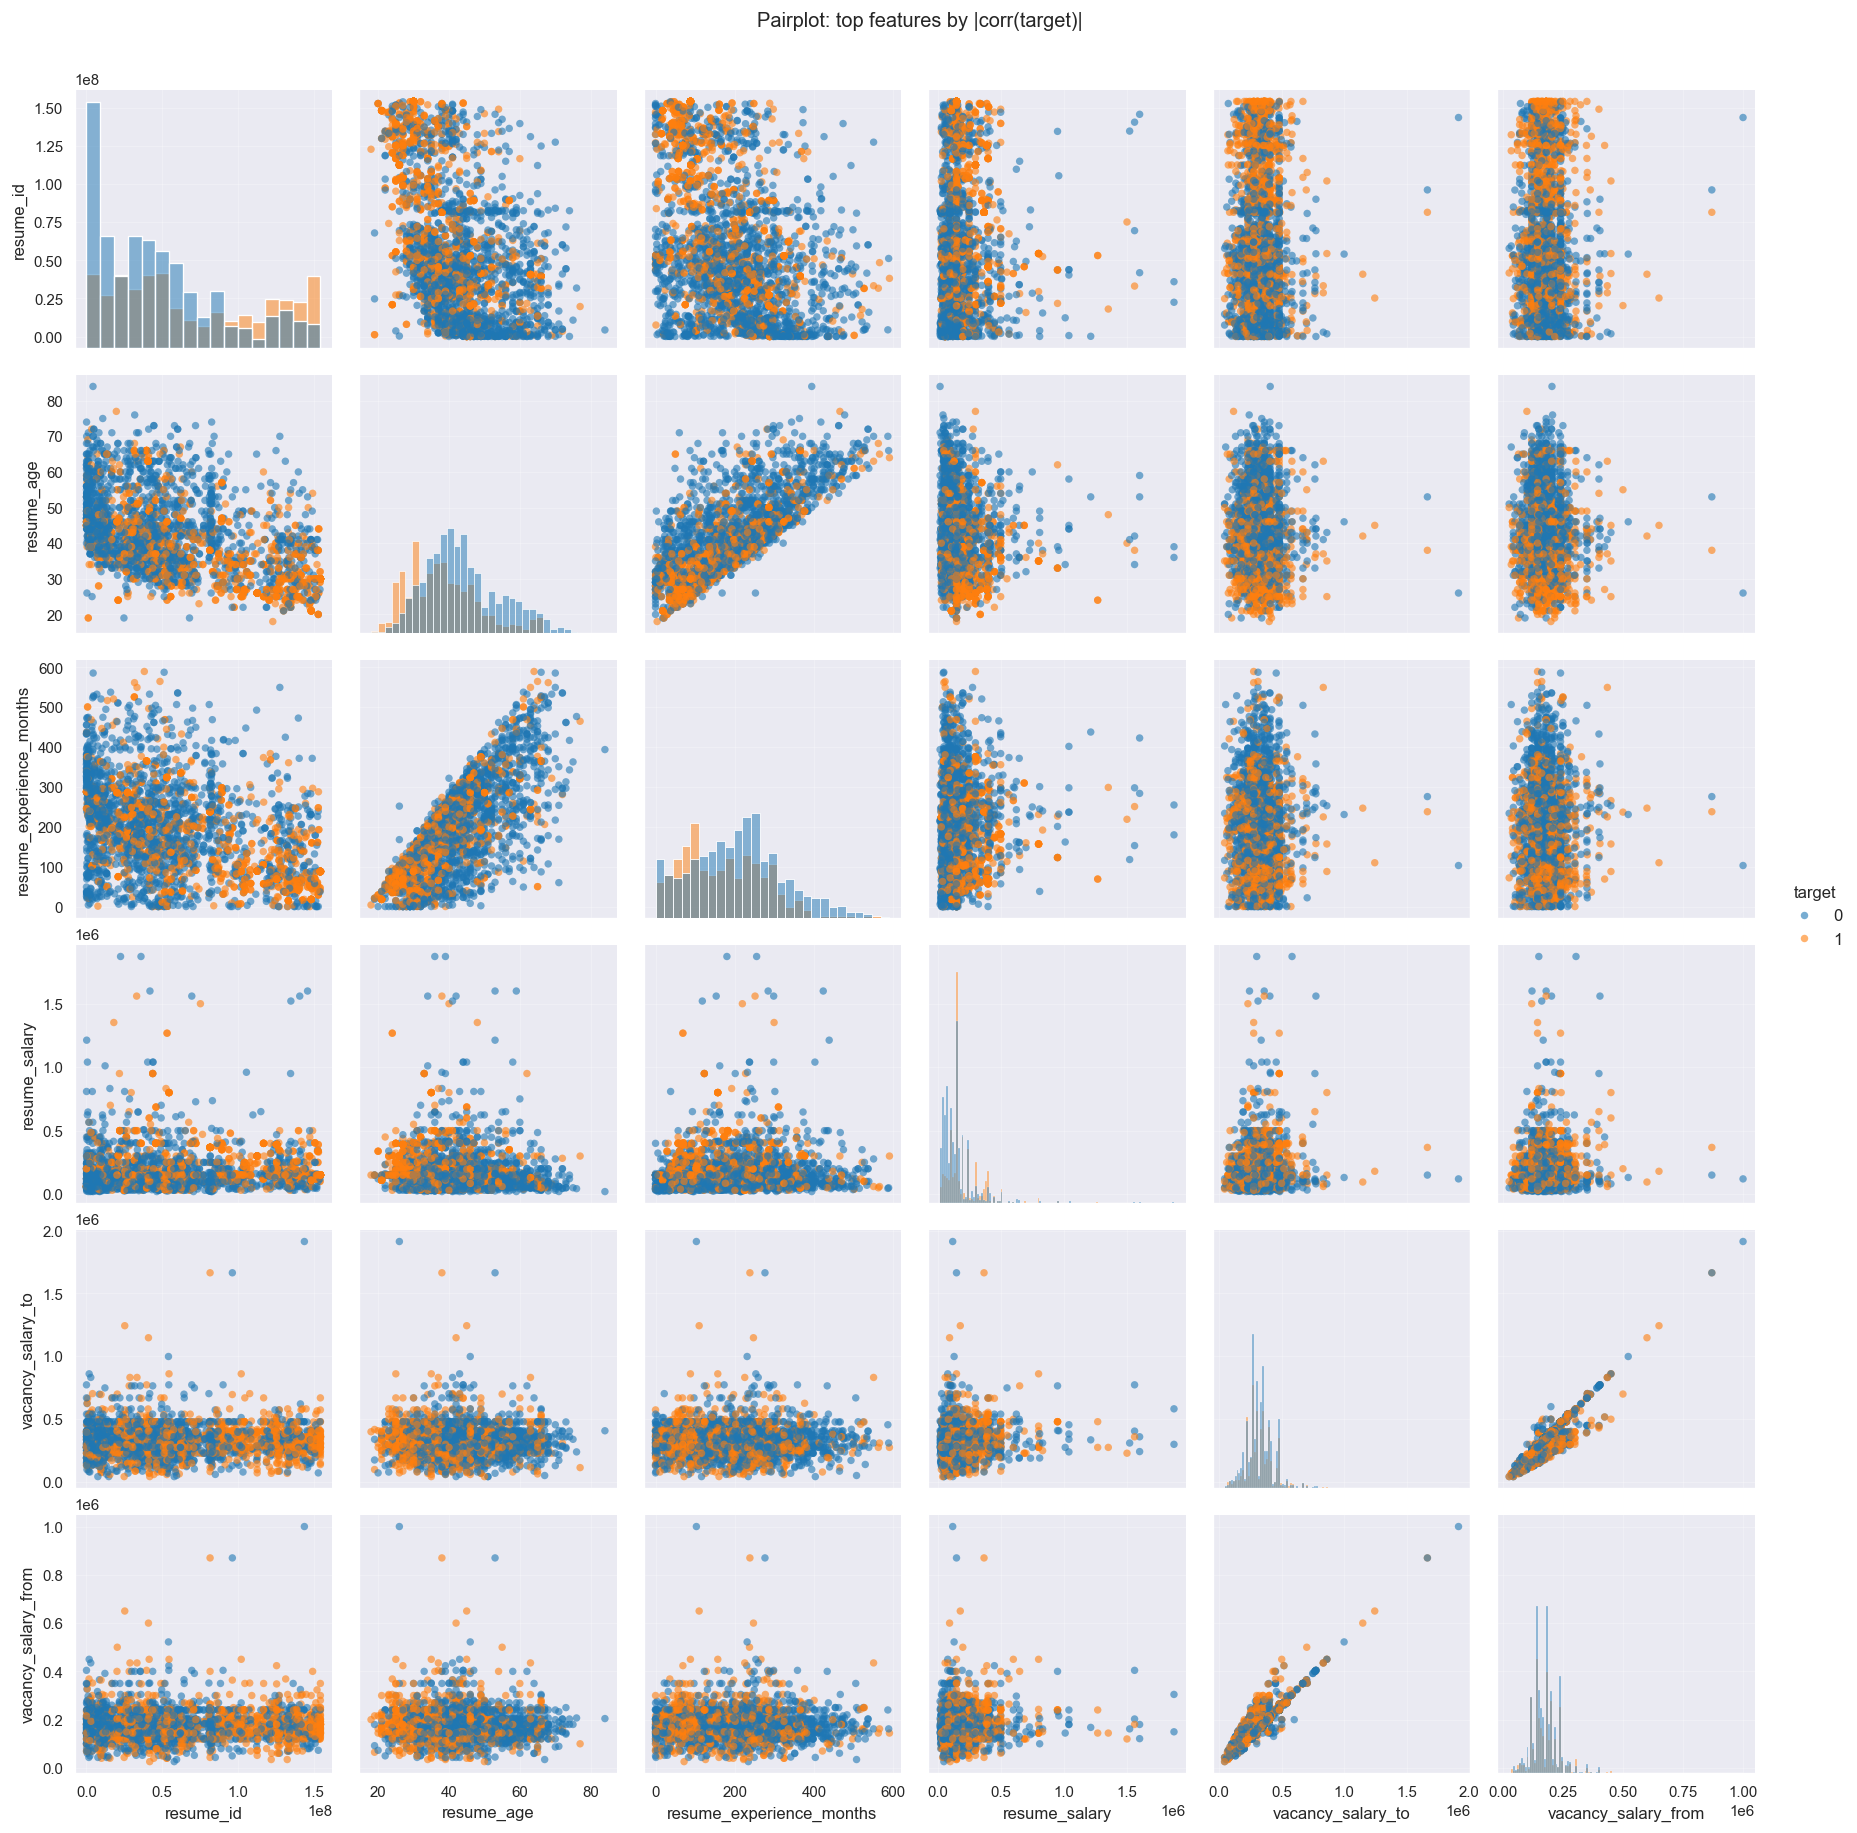

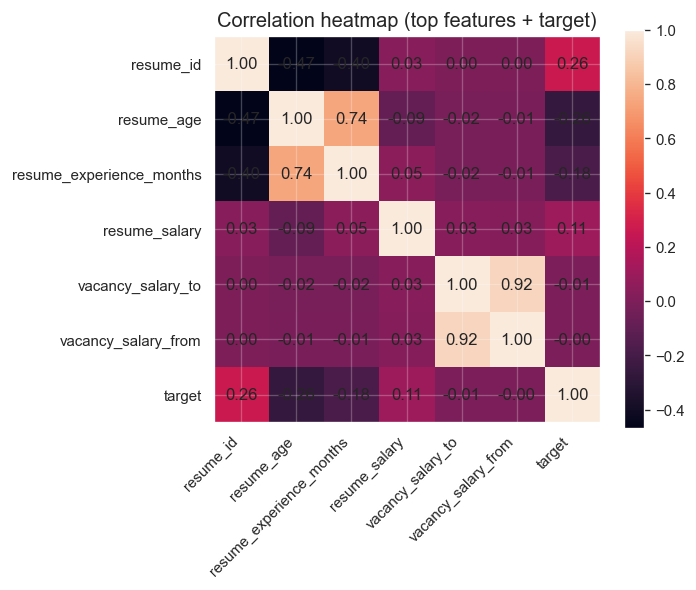


=== Statistically significant vs target (alpha=0.05) ===
                 feature  pearson_r  pearson_p  spearman_rho  spearman_p     n
               resume_id          0          0             0           0 58302
              resume_age         -0          0            -0           0 58302
resume_experience_months         -0          0            -0           0 58302
           resume_salary          0          0             0           0 58302
       vacancy_salary_to         -0          0            -0           0 58302
     vacancy_salary_from         -0          0            -0           0 58302


In [35]:
try:
    import seaborn as sns
    HAS_SNS = True
except Exception:
    HAS_SNS = False

# 0) Загрузка (если df не определён)
try:
    df
except NameError:
    df = pd.read_csv("df_to_analyze.csv")

# Убедимся, что target — числовой
df["target"] = pd.to_numeric(df["target"], errors="coerce")

# 1) Числовые колонки
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "target"]

# 2) Корреляции с target: Pearson и Spearman (+ p-values)
rows = []
for col in num_cols:
    x = pd.to_numeric(df[col], errors="coerce")
    y = df["target"]
    m = pd.concat([x, y], axis=1).dropna()
    if len(m) >= 3 and m["target"].nunique() > 1:
        r_p, p_p = pearsonr(m[col], m["target"])
        r_s, p_s = spearmanr(m[col], m["target"])
        rows.append({
            "feature": col,
            "pearson_r": r_p, "pearson_p": p_p,
            "spearman_rho": r_s, "spearman_p": p_s,
            "n": len(m)
        })
corr_target_df = pd.DataFrame(rows).sort_values("pearson_r", key=lambda s: s.abs(), ascending=False)
print("\n=== Corr with target (numeric only), sorted by |Pearson r| ===")
print(corr_target_df.head(30).to_string(index=False))

# Сохраним на диск
# corr_target_df.to_csv("corr_with_target.csv", index=False)

# 3) Общая попарная корреляционная матрица (Pearson) по числовым
corr_all = df[num_cols + ["target"]].corr(method="pearson")
# corr_all.to_csv("full_corr_matrix.csv")
# print("\nSaved: full_corr_matrix.csv, corr_with_target.csv")

# 4) Выбор топ-фич по |corr(target)|:
TOP_N = 6
top_features = corr_target_df["feature"].head(TOP_N).tolist()
cols_for_plots = [*top_features, "target"]

# 5) Pairplot / scatter matrix
plot_df = df[cols_for_plots].dropna()
if len(plot_df) > 3000:
    plot_df = plot_df.sample(3000, random_state=42)

if len(cols_for_plots) >= 2 and not plot_df.empty:
    if HAS_SNS:
        # seaborn pairplot с оттенком по target
        g = sns.pairplot(plot_df, hue="target", diag_kind="hist", plot_kws={"alpha":0.6, "s":20, "edgecolor":"none"})
        g.fig.suptitle("Pairplot: top features by |corr(target)|", y=1.02)
        plt.show()
    else:
        # Fallback: pandas scatter_matrix (без окраски по target)
        axes = scatter_matrix(plot_df.drop(columns=["target"]), figsize=(10,10), diagonal="hist")
        plt.suptitle("Scatter Matrix (fallback): top features (no seaborn)", y=1.02)
        plt.tight_layout()
        plt.show()

# 6) Теплокарта корреляций для топ-фич (чистый matplotlib)
sub = df[cols_for_plots].dropna()
if sub.shape[1] >= 2 and not sub.empty:
    sub_corr = sub.corr(method="pearson")
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(sub_corr.values, interpolation="nearest")
    ax.set_xticks(range(len(sub_corr.columns)))
    ax.set_yticks(range(len(sub_corr.columns)))
    ax.set_xticklabels(sub_corr.columns, rotation=45, ha="right")
    ax.set_yticklabels(sub_corr.columns)
    for (i, j), val in np.ndenumerate(sub_corr.values):
        ax.text(j, i, f"{val:.2f}", ha="center", va="center")
    ax.set_title("Correlation heatmap (top features + target)")
    fig.colorbar(im)
    plt.tight_layout()
    plt.show()

# 7) (Опционально) Быстрая табличка значимостей: отфильтруем по p-value
alpha = 0.05
sig = corr_target_df[(corr_target_df["pearson_p"] < alpha) | (corr_target_df["spearman_p"] < alpha)]
print("\n=== Statistically significant vs target (alpha=0.05) ===")
print(sig.to_string(index=False))
# sig.to_csv("corr_with_target_significant.csv", index=False)


В данном рассмотрении обычные линейные корреляции - не самый подходящий инструмент для оценки влияниия признаков на целевую переменную